In [1]:
import pandas as pd 
import numpy as np 
import nltk
import nltk.corpus
from nltk.corpus import words
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
'''
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

import re 
import random

import spacy 
import emoji 
import contractions
import pickle
import string
from autocorrect import Speller
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  # stopwords are removed from text data in NLP tasks because they don't have meaning ex the, is or an, 
import nltk
from num2words import num2words
from nltk.stem import SnowballStemmer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay'''

"\nfrom nltk.util import ngrams\nfrom nltk.tokenize import word_tokenize\n\nimport re \nimport random\n\nimport spacy \nimport emoji \nimport contractions\nimport pickle\nimport string\nfrom autocorrect import Speller\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import TfidfTransformer\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom nltk.corpus import stopwords  # stopwords are removed from text data in NLP tasks because they don't have meaning ex the, is or an, \nimport nltk\nfrom num2words import num2words\nfrom nltk.stem import SnowballStemmer\nimport sklearn\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport xgboost\nfrom sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay"

In [2]:
data_path = '/Users/abdoulabdillahi/Desktop/CSC 680/Final_project/data/slang.csv'
df = pd.read_csv(data_path)

In [3]:
df.tail()

,Unnamed: 0,acronym,expansion
3352,3352,yw,you are welcome
3353,3353,ywca,young womens christian association
3354,3354,ywimc,your wish is my command
3355,3355,ywsyls,you win some you lose some
3356,3356,ywu,yo waz up


In [4]:
df.shape

(3357, 3)

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [6]:
df.shape

(3357, 2)

In [7]:
df.tail(10)

,acronym,expansion
3347,yto,you are the one
3348,ytp,youtube poop
3349,yttm,you talk too much you talking to me
3350,yum,said when something tastes good or is attractive
3351,yvw,you are very welcome
3352,yw,you are welcome
3353,ywca,young womens christian association
3354,ywimc,your wish is my command
3355,ywsyls,you win some you lose some
3356,ywu,yo waz up


In [8]:
import random
# Sample dataset of acronyms and expansions
acronyms_expansions = {
    "2day": "today",
    "2m2h": "too much too handle",
    "2moro": "tomorrow",
    "2nite": "tonight",
    "4eae": "for ever and ever",
    "yto":"you are the one"
    # Add more acronyms and expansions as needed
}

def generate_text_with_acronyms(acronyms_expansions, num_sentences=5):
    sentences = []
    num_acronyms = len(acronyms_expansions)
    for _ in range(num_sentences):
        sentence = []
        # Randomly choose acronyms and use them in the sentence
        num_acronyms_to_use = min(random.randint(1, num_acronyms), num_acronyms)
        for acronym, expansion in random.sample(list(acronyms_expansions.items()), num_acronyms_to_use):
           sentence.append(random.choice([acronym, expansion]))
    sentences.append(" ".join(sentence))
    return " ".join(sentences)

# Generate text using acronyms
generated_text = generate_text_with_acronyms(acronyms_expansions)
print(generated_text)


2nite for ever and ever 2moro today yto 2m2h


In [9]:
def generate_text_with_acronyms(df, num_sentences=5, num_acronyms_to_use=5):
    sentences = []
    for _ in range(num_sentences):
        sentence = []
        # Randomly choose acronyms and use them in the sentence
        sampled_acronyms = random.sample(range(len(df)), min(num_acronyms_to_use, len(df)))
        for idx in sampled_acronyms:
            acronym, expansion = df.iloc[idx]['acronym'], df.iloc[idx]['expansion']
            # Construct the sentence using the acronym and its expansion
            sentence.append(random.choice([acronym, expansion]))
        sentences.append(" ".join(sentence))
    return " ".join(sentences)

In [10]:
# creating a new column to generate synthetic text 
df['synthetic_text'] = df.apply( lambda row:generate_text_with_acronyms(df, num_sentences=1, num_acronyms_to_use=5), axis=1)

In [11]:
pd.set_option('display.max_colwidth', 255)

In [12]:
df.head(10)

,acronym,expansion,synthetic_text
0,2day,today,god be with you you had to be there sex and the city evil laugh out loud uniform resource indicator url
1,2m2h,too much too handle,gtm nfz not my job phb tgod
2,2moro,tomorrow,republican in name only love and kisses wtmi tylj mysm
3,2nite,tonight,nmo thank you very much tell me more region 5 hit be back
4,4eae,for ever and ever,ilytb lmc stay at home dad idc good to see you
5,aaf,as a friend,you are welcome nla tbqfh bugging beyond belief pnc
6,aar,at any rate,i see what you did there in real life rock against communism mgd smop
7,aayf,as always your friend,how goes it believe it comrade you be the judge gafia much clown love
8,abd,already been done,nmg hit the cell what the hell is wrong with you nbif ikr
9,ack,acknowledge,ins to be totally honest what is your problem what is your point wltm music publishers association


In [13]:
# Standard Vocabulary 
vocabulary = set(words.words())   # Set stores data 
len(vocabulary)

235892

Preprocessing Steps 
. Remove Punctuation 
. Convert to LowerCase
. Tokenization 

Tokenization : is the process of breaking down text into smaller units 
Stemming: is the process of reducing words to a common base form 

In [14]:
# Tokenisation
tokenizer = WhitespaceTokenizer()
def tokenise(text):
    return tokenizer.tokenize(str(text))

df['tokenized_text'] = df['synthetic_text'].apply(lambda x: tokenise(x))

In [15]:
df.head(10)

,acronym,expansion,synthetic_text,tokenized_text
0,2day,today,god be with you you had to be there sex and the city evil laugh out loud uniform resource indicator url,"[god, be, with, you, you, had, to, be, there, sex, and, the, city, evil, laugh, out, loud, uniform, resource, indicator, url]"
1,2m2h,too much too handle,gtm nfz not my job phb tgod,"[gtm, nfz, not, my, job, phb, tgod]"
2,2moro,tomorrow,republican in name only love and kisses wtmi tylj mysm,"[republican, in, name, only, love, and, kisses, wtmi, tylj, mysm]"
3,2nite,tonight,nmo thank you very much tell me more region 5 hit be back,"[nmo, thank, you, very, much, tell, me, more, region, 5, hit, be, back]"
4,4eae,for ever and ever,ilytb lmc stay at home dad idc good to see you,"[ilytb, lmc, stay, at, home, dad, idc, good, to, see, you]"
5,aaf,as a friend,you are welcome nla tbqfh bugging beyond belief pnc,"[you, are, welcome, nla, tbqfh, bugging, beyond, belief, pnc]"
6,aar,at any rate,i see what you did there in real life rock against communism mgd smop,"[i, see, what, you, did, there, in, real, life, rock, against, communism, mgd, smop]"
7,aayf,as always your friend,how goes it believe it comrade you be the judge gafia much clown love,"[how, goes, it, believe, it, comrade, you, be, the, judge, gafia, much, clown, love]"
8,abd,already been done,nmg hit the cell what the hell is wrong with you nbif ikr,"[nmg, hit, the, cell, what, the, hell, is, wrong, with, you, nbif, ikr]"
9,ack,acknowledge,ins to be totally honest what is your problem what is your point wltm music publishers association,"[ins, to, be, totally, honest, what, is, your, problem, what, is, your, point, wltm, music, publishers, association]"


In [16]:

# This function evaluate the tokenized text 
def evaluate_text(tokenized_text):
    return tokenized_text in vocabulary

df['evaluation_text'] = df['tokenized_text'].apply(lambda x: [evaluate_text(tokenized_text) for tokenized_text in x])

In [17]:
df.head()

,acronym,expansion,synthetic_text,tokenized_text,evaluation_text
0,2day,today,god be with you you had to be there sex and the city evil laugh out loud uniform resource indicator url,"[god, be, with, you, you, had, to, be, there, sex, and, the, city, evil, laugh, out, loud, uniform, resource, indicator, url]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]"
1,2m2h,too much too handle,gtm nfz not my job phb tgod,"[gtm, nfz, not, my, job, phb, tgod]","[False, False, True, True, True, False, False]"
2,2moro,tomorrow,republican in name only love and kisses wtmi tylj mysm,"[republican, in, name, only, love, and, kisses, wtmi, tylj, mysm]","[True, True, True, True, True, True, False, False, False, False]"
3,2nite,tonight,nmo thank you very much tell me more region 5 hit be back,"[nmo, thank, you, very, much, tell, me, more, region, 5, hit, be, back]","[False, True, True, True, True, True, True, True, True, False, True, True, True]"
4,4eae,for ever and ever,ilytb lmc stay at home dad idc good to see you,"[ilytb, lmc, stay, at, home, dad, idc, good, to, see, you]","[False, False, True, True, True, True, False, True, True, True, True]"


In [18]:
# Calculation the distribution of True and False values 
true_counts = df['evaluation_text'].apply(lambda x: x.count(True))
false_Counts = df['evaluation_text'].apply(lambda x: x.count(False))

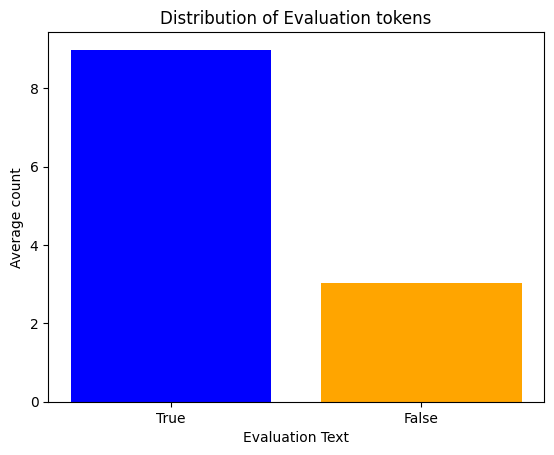

In [19]:
# Visualize the distribution using bar plot 
plt.bar(['True', 'False'], [true_counts.mean(), false_Counts.mean()], color=['blue', 'orange'])
plt.xlabel('Evaluation Text')
plt.ylabel('Average count')
plt.title('Distribution of Evaluation tokens')
plt.show()

In [20]:
# Function to filter out non-English words 
def filter_non_english_words(tokens, evaluation):
    english_text = [token for token , is_english in zip(tokens, evaluation) if is_english]
    return english_text

In [21]:
df['filtered_text'] = df.apply(lambda row: filter_non_english_words(row['tokenized_text'], row['evaluation_text']), axis=1)

In [22]:
df.head(10)

,acronym,expansion,synthetic_text,tokenized_text,evaluation_text,filtered_text
0,2day,today,god be with you you had to be there sex and the city evil laugh out loud uniform resource indicator url,"[god, be, with, you, you, had, to, be, there, sex, and, the, city, evil, laugh, out, loud, uniform, resource, indicator, url]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]","[god, be, with, you, you, had, to, be, there, sex, and, the, city, evil, laugh, out, loud, uniform, resource, indicator]"
1,2m2h,too much too handle,gtm nfz not my job phb tgod,"[gtm, nfz, not, my, job, phb, tgod]","[False, False, True, True, True, False, False]","[not, my, job]"
2,2moro,tomorrow,republican in name only love and kisses wtmi tylj mysm,"[republican, in, name, only, love, and, kisses, wtmi, tylj, mysm]","[True, True, True, True, True, True, False, False, False, False]","[republican, in, name, only, love, and]"
3,2nite,tonight,nmo thank you very much tell me more region 5 hit be back,"[nmo, thank, you, very, much, tell, me, more, region, 5, hit, be, back]","[False, True, True, True, True, True, True, True, True, False, True, True, True]","[thank, you, very, much, tell, me, more, region, hit, be, back]"
4,4eae,for ever and ever,ilytb lmc stay at home dad idc good to see you,"[ilytb, lmc, stay, at, home, dad, idc, good, to, see, you]","[False, False, True, True, True, True, False, True, True, True, True]","[stay, at, home, dad, good, to, see, you]"
5,aaf,as a friend,you are welcome nla tbqfh bugging beyond belief pnc,"[you, are, welcome, nla, tbqfh, bugging, beyond, belief, pnc]","[True, True, True, False, False, False, True, True, False]","[you, are, welcome, beyond, belief]"
6,aar,at any rate,i see what you did there in real life rock against communism mgd smop,"[i, see, what, you, did, there, in, real, life, rock, against, communism, mgd, smop]","[True, True, True, True, True, True, True, True, True, True, True, True, False, False]","[i, see, what, you, did, there, in, real, life, rock, against, communism]"
7,aayf,as always your friend,how goes it believe it comrade you be the judge gafia much clown love,"[how, goes, it, believe, it, comrade, you, be, the, judge, gafia, much, clown, love]","[True, True, True, True, True, True, True, True, True, True, False, True, True, True]","[how, goes, it, believe, it, comrade, you, be, the, judge, much, clown, love]"
8,abd,already been done,nmg hit the cell what the hell is wrong with you nbif ikr,"[nmg, hit, the, cell, what, the, hell, is, wrong, with, you, nbif, ikr]","[False, True, True, True, True, True, True, True, True, True, True, False, False]","[hit, the, cell, what, the, hell, is, wrong, with, you]"
9,ack,acknowledge,ins to be totally honest what is your problem what is your point wltm music publishers association,"[ins, to, be, totally, honest, what, is, your, problem, what, is, your, point, wltm, music, publishers, association]","[False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True]","[to, be, totally, honest, what, is, your, problem, what, is, your, point, music, association]"


In [23]:
df['synthetic_text'][0:10]

0    god be with you you had to be there sex and the city  evil laugh out loud uniform resource indicator url
1                                                                                 gtm nfz not my job phb tgod
2                                                      republican in name only love and kisses wtmi tylj mysm
3                                                  nmo thank you very much tell me more region 5  hit be back
4                                                              ilytb lmc stay at home dad idc good to see you
5                                                         you are welcome nla tbqfh bugging beyond belief pnc
6                                       i see what you did there in real life rock against communism mgd smop
7                                       how goes it believe it comrade you be the judge gafia much clown love
8                                                   nmg hit the cell what the hell is wrong with you nbif ikr
9         